In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import tifffile
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [41]:
! ls /kaggle/input/satellite-imagery/data

images	labels


In [42]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.file_pairs = []

        image_files = sorted([f for f in os.listdir(image_dir) if not f.startswith('.')])
        mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir) if not f.startswith('.')}

        
        for img_file in image_files:
            img_basename = os.path.splitext(img_file)[0]
            if img_basename in mask_files:
                mask_file = mask_files[img_basename]
                self.file_pairs.append(
                    (os.path.join(image_dir, img_file), os.path.join(mask_dir, mask_file))
                )

    def __len__(self):
        return len(self.file_pairs)

    def _load_image(self, path):
        """Robustly loads an image, trying tifffile then Pillow."""
        try:
            
            return tifffile.imread(path)
        except tifffile.TiffFileError:
            
            
            img = Image.open(path)
            return np.array(img)

    def __getitem__(self, idx):
        img_path, mask_path = self.file_pairs[idx]

        
        image = self._load_image(img_path)
        mask = self._load_image(mask_path)
        
        
        
        if image.shape[-1] == 4:
            image = image[..., :3]

        
        if len(mask.shape) == 3:
            mask = mask[..., 0]

        
        mask = mask.astype(np.float32)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


def simple_transform(image, mask):
    image = TF.to_tensor(image)
    image = image.float()
    mask = torch.from_numpy(mask).long()
    
    return image, mask

In [43]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [44]:

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        
        
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        
        x = self.up1(x5)
        
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        
        logits = self.outc(x)
        return logits

model_test = UNet(n_channels=12, n_classes=2).to(device)
dummy_input = torch.randn(1, 12, 256, 256).to(device) 
output = model_test(dummy_input)
print("Model created successfully!")
print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)

del model_test

Model created successfully!
Input shape: torch.Size([1, 12, 256, 256])
Output shape: torch.Size([1, 2, 256, 256])


In [45]:


LEARNING_RATE = 1e-4
BATCH_SIZE = 4
EPOCHS = 50
IMAGE_DIR = "/kaggle/input/satellite-imagery/data/images"  
MASK_DIR = "/kaggle/input/satellite-imagery/data/labels"   
VAL_PERCENT = 0.1 


dataset = SegmentationDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    transform=simple_transform
)


n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])


train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Dataset created with {len(dataset)} samples.")
print(f"Training set has {len(train_set)} samples.")
print(f"Validation set has {len(val_set)} samples.")




criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Dataset created with 306 samples.
Training set has 276 samples.
Validation set has 30 samples.


In [46]:

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train() 
    running_loss = 0.0

    for i, (images, masks) in enumerate(loader):
        images = images.to(device)
        masks = masks.to(device)
        
        
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    return running_loss / len(loader)

def evaluate(loader, model, loss_fn, device):
    model.eval() 
    running_loss = 0.0
    
    with torch.no_grad(): 
        for i, (images, masks) in enumerate(loader):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()
            
    return running_loss / len(loader)


In [47]:
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(train_loader, model, optimizer, criterion, device)
    val_loss = evaluate(val_loader, model, criterion, device)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/50, Train Loss: 0.2148, Val Loss: 0.1397
Epoch 2/50, Train Loss: 0.1937, Val Loss: 0.1533
Epoch 3/50, Train Loss: 0.1957, Val Loss: 0.1342
Epoch 4/50, Train Loss: 0.1908, Val Loss: 0.1370
Epoch 5/50, Train Loss: 0.1818, Val Loss: 0.1315
Epoch 6/50, Train Loss: 0.1865, Val Loss: 0.1448
Epoch 7/50, Train Loss: 0.1828, Val Loss: 0.1578
Epoch 8/50, Train Loss: 0.1661, Val Loss: 0.1279
Epoch 9/50, Train Loss: 0.1703, Val Loss: 0.1501
Epoch 10/50, Train Loss: 0.1757, Val Loss: 0.1360
Epoch 11/50, Train Loss: 0.1685, Val Loss: 0.1519
Epoch 12/50, Train Loss: 0.1709, Val Loss: 0.1126
Epoch 13/50, Train Loss: 0.1588, Val Loss: 0.1299
Epoch 14/50, Train Loss: 0.1426, Val Loss: 0.1103
Epoch 15/50, Train Loss: 0.1698, Val Loss: 0.4775
Epoch 16/50, Train Loss: 0.1874, Val Loss: 0.1384
Epoch 17/50, Train Loss: 0.1641, Val Loss: 0.1184
Epoch 18/50, Train Loss: 0.1412, Val Loss: 0.1061
Epoch 19/50, Train Loss: 0.1362, Val Loss: 0.0962
Epoch 20/50, Train Loss: 0.1379, Val Loss: 0.0959
Epoch 21/

In [48]:

def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    fig, ax = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    rgb_channels = [3, 2, 1]

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, mask = dataset[idx] 
        
        input_image_tensor = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_image_tensor)
            
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        image_for_plot = image[rgb_channels, :, :].permute(1, 2, 0).cpu().numpy()
        
        min_val = image_for_plot.min(axis=(0, 1), keepdims=True)
        max_val = image_for_plot.max(axis=(0, 1), keepdims=True)
        image_for_plot = (image_for_plot - min_val) / (max_val - min_val)
        
        ground_truth_mask = mask.cpu().numpy()
        
        
        ax[i, 0].imshow(image_for_plot)
        ax[i, 0].set_title("Original Image (False Color)")
        ax[i, 0].axis('off')

        ax[i, 1].imshow(ground_truth_mask, cmap='gray')
        ax[i, 1].set_title("Ground Truth Mask")
        ax[i, 1].axis('off')
        
        ax[i, 2].imshow(pred_mask, cmap='gray')
        ax[i, 2].set_title("Predicted Mask")
        ax[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

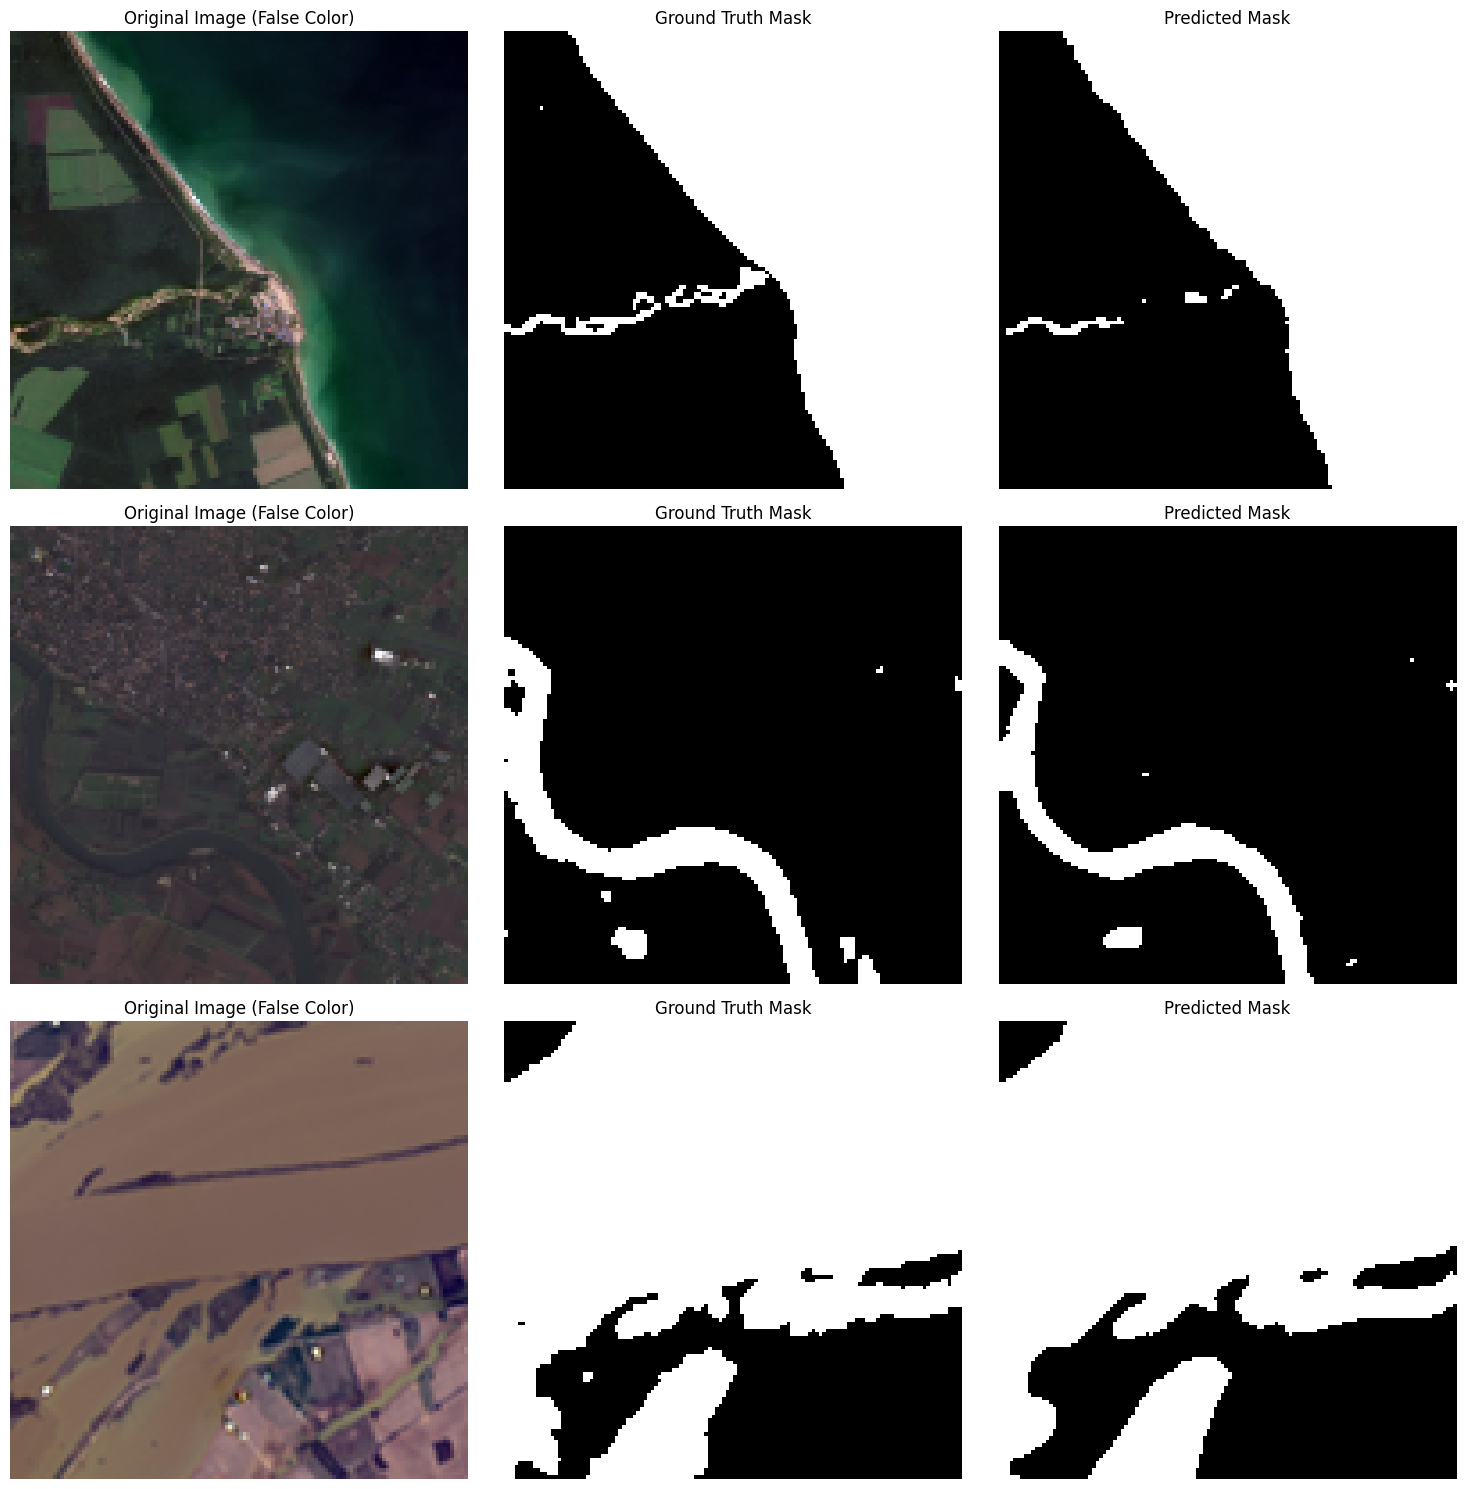

In [49]:
visualize_predictions(model, val_set.dataset, device, num_samples=3)